In [1]:
import numpy as np
import pandas as pd
from spoc import generate_spoc_model as gen_model
from spoc import spoc 
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
matplotlib.rcParams.update({'font.size': 18})

from tqdm import tqdm_notebook
from IPython.display import clear_output, display

%matplotlib inline

In [2]:
### number of nodes
n_nodes = 1000

### number of clusters
n_clusters = 2

### number of pure nodes
### check article 
### https://arxiv.org/abs/1707.01350
pnn = 10
pure_inds = list(range(10))

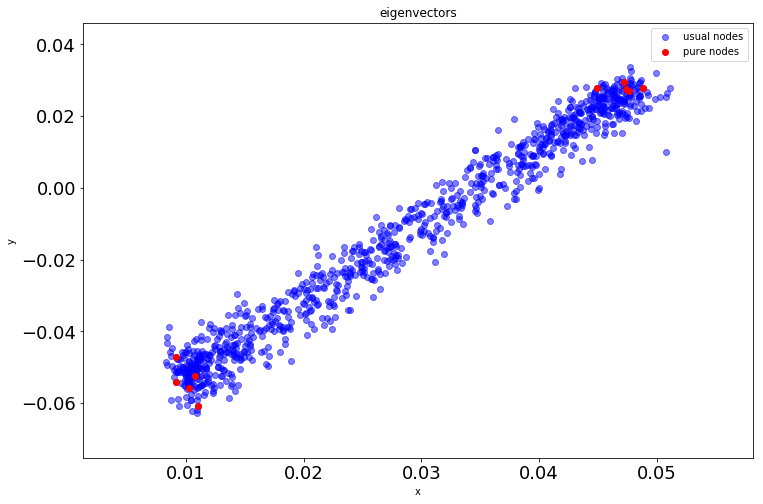

In [3]:
### Now let's generate some toy examples
### Firstly, generate Theta matrix
Theta = gen_model.generate_theta(n_nodes,
                                n_clusters,
                                pnn,
                                pure_nodes_indices = 
                                pure_inds,
                                seed=42)
### Fix B matrix
B = np.array([[0.7, 0], [0, 0.3]])
P = Theta.dot(B).dot(Theta.T)

### Finally, create adjacency matrix
### from P matrix via Bernoulli distribution
A = gen_model.P_to_A(P)

### Draw 2 eigenvectors corresponding
### to the 2 largest eigenvalues
U, L = spoc.SPOC._get_U_L(A, n_clusters)
plt.figure(figsize=(12, 8))
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(U[:, 0], U[:, 1], c='b', alpha=0.5,
           label='usual nodes')
plt.scatter(U[pure_inds, 0], U[pure_inds, 1], c='r',
            alpha=1, label='pure nodes')
plt.title('eigenvectors')
plt.legend()

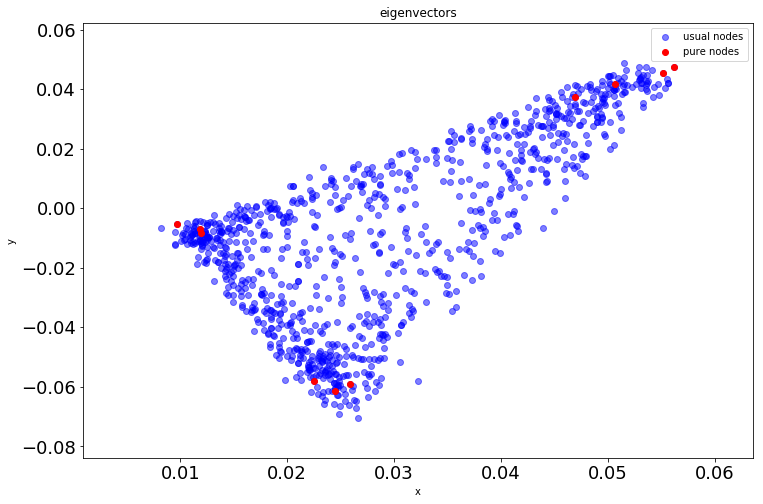

In [4]:
n_clusters = 3
Theta = gen_model.generate_theta(n_nodes,
                                n_clusters,
                                pnn,
                                pure_nodes_indices = 
                                pure_inds,
                                seed=42)

B = np.array([[0.7, 0, 0], [0, 0.5, 0], [0, 0, 0.3]])
P = Theta.dot(B).dot(Theta.T)
A = gen_model.P_to_A(P)
U, L = spoc.SPOC._get_U_L(A, n_clusters)
plt.figure(figsize=(12, 8))
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(U[:, 0], U[:, 1], c='b', alpha=0.5,
           label='usual nodes')
plt.scatter(U[pure_inds, 0], U[pure_inds, 1], c='r',
            alpha=1, label='pure nodes')
plt.title('eigenvectors')
plt.legend()

In [5]:
### Create SPOC object to recover Theta
### and B matrices from adjacency matrix

spoc_obj = spoc.SPOC(A, n_clusters)
Theta_exp, B_exp = spoc_obj.fit()

### check error of recovering
err, _ = gen_model.find_permutation_Theta(Theta, Theta_exp)
print('relative error in Theta matrix recovering {}'.format(err))

err, _ = gen_model.find_permutation_B(B, B_exp)
print('relative error in B matrix recovering {}'.format(err))

relative error in Theta matrix recovering 0.133266577599
relative error in B matrix recovering 0.249255375005


In [6]:
### Demonstrate how bootstrap works
### In order to draw confidence interval

A, _, _ = gen_model.generate_a(n_nodes, n_clusters,
                               pnn, seed=13)

spoc_obj = spoc.SPOC(A, n_clusters,
                    use_bootstrap=True,
                    n_repetitions=100,
                    return_bootstrap_matrix=True)

U, L = spoc.SPOC._get_U_L(A, n_clusters)
Theta, B, bootstrap_matrix = spoc_obj.fit()

In [7]:
### Implement some function to draw
### the ellips

from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [8]:
### Find the node with the largest norm
### in eigenvectors coordinates
max_index = np.argsort(-np.linalg.norm(U, axis=1))[0]

In [9]:
bootstrap_matrix.shape

(100, 1000, 3)

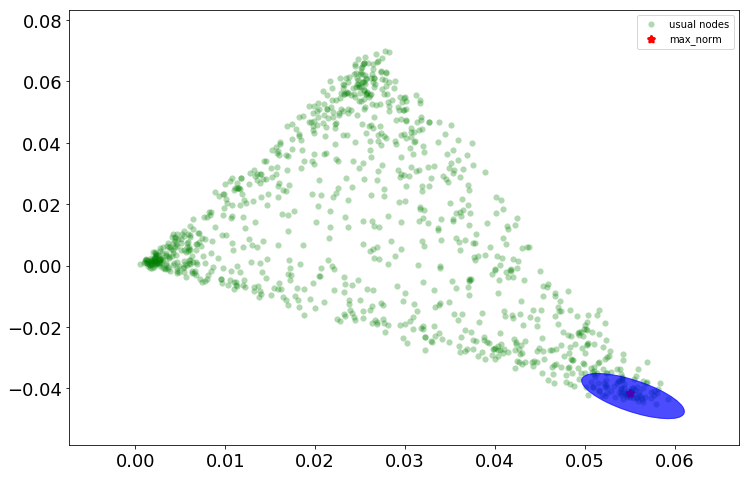

In [10]:
plt.figure(figsize=(12, 8))
plt.scatter(U[:, 0], U[:, 1], label="usual nodes",
            linewidths=0.1, c="g", alpha=0.3)

plt.scatter(U[max_index, 0], U[max_index, 1], label="max_norm",
            marker='*', c="r", alpha=1, linewidths=3)

plot_point_cov(bootstrap_matrix[:,max_index, :2], nstd=2, alpha=0.7, color="b")
plt.legend()

In [11]:
### Bootstrap method gets average of 
### nodes coordinates inside ellipsoid
### and use this average coordinates for
### classic SPA algorithm

In [12]:
### Check the result of
### bootstrap algorithm

n_clusters = 2
A, Theta, B = gen_model.generate_a(n_nodes,
                                   n_clusters,
                                   pnn, seed=1)

spoc_obj = spoc.SPOC(A, n_clusters,
                     use_bootstrap=True,
                     n_repetitions=100)

Theta_exp, B_exp = spoc_obj.fit()

### check error of recovering
err, _ = gen_model.find_permutation_Theta(Theta, Theta_exp)
print('relative error in Theta matrix recovering {}'.format(err))

err, _ = gen_model.find_permutation_B(B, B_exp)
print('relative error in B matrix recovering {}'.format(err))

relative error in Theta matrix recovering 0.054569085255
relative error in B matrix recovering 0.0234948921007
